# Creating the BB on the unclustered dataset and compute clusters only on the validation set

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from pathlib import Path
import os
import sys
import bz2
import pickle
import category_encoders as ce
np.random.seed(10)
# adds the visibility of the mlem module, needed to load the attack models
sys.path.append("../../../") 
import mlem

# GETTING THE DATASET
Here I download the dataset (3/4 Mb, but pandas is a bit slow to download it), delete the rows with missing values and replace the targets with a 0 and 1 instead of '<=50K', '>50K'

In [2]:
DATASET_PATH = Path("./adult.data")
DATASET_URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data' if not DATASET_PATH.exists() else DATASET_PATH
columns = ['Age', 'Workclass', 'Fnlwgt', 'Education', 'Education-num', 'Marital-status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Capital-gain', 'Capital-loss', 'Hours-per-week', 'Native-country', 'Target']
df = pd.read_csv(DATASET_URL, names=columns, na_values=['?', ' ?', '? '])

In [3]:
# strip the strings
df_str = df.select_dtypes(['object'])
df[df_str.columns] = df_str.apply(lambda x: x.str.strip())
# remove missing values and duplicates
df = df.dropna()
df = df.drop_duplicates()
# map the target into {0,1}
map_targ = {
        '<=50K': 0,
        '>50K': 1
}

feat = df.iloc[:, :-1]
targ = df.iloc[:, -1]
targ = targ.map(map_targ)

targenc = ce.TargetEncoder(verbose=1,return_df=True)
df = targenc.fit_transform(feat, targ)
df['Target'] = targ

In [4]:
df

,Age,Workclass,Fnlwgt,Education,Education-num,Marital-status,Occupation,Relationship,Race,Sex,Capital-gain,Capital-loss,Hours-per-week,Native-country,Target
0,39,0.268960,77516,0.421658,13,0.048399,0.133907,0.106689,0.263855,0.313955,2174,0,40,0.254411,0
1,50,0.285829,83311,0.421658,13,0.455011,0.485342,0.455728,0.263855,0.313955,0,0,13,0.254411,0
2,38,0.218918,215646,0.164328,9,0.107312,0.061527,0.106689,0.263855,0.313955,0,0,40,0.254411,0
3,53,0.218918,234721,0.056298,7,0.455011,0.061527,0.455728,0.129972,0.313955,0,0,40,0.254411,0
4,28,0.218918,338409,0.421658,13,0.455011,0.448686,0.493599,0.129972,0.113783,0,0,40,0.271739,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,0.218918,257302,0.253968,12,0.455011,0.305159,0.493599,0.263855,0.113783,0,0,38,0.254411,0
32557,40,0.218918,154374,0.164328,9,0.455011,0.124236,0.455728,0.263855,0.313955,0,0,40,0.254411,1
32558,58,0.218918,151910,0.164328,9,0.096735,0.133907,0.066334,0.263855,0.113783,0,0,40,0.254411,0
32559,22,0.218918,201490,0.164328,9,0.048399,0.133907,0.014343,0.263855,0.313955,0,0,20,0.254411,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30139 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             30139 non-null  int64  
 1   Workclass       30139 non-null  float64
 2   Fnlwgt          30139 non-null  int64  
 3   Education       30139 non-null  float64
 4   Education-num   30139 non-null  int64  
 5   Marital-status  30139 non-null  float64
 6   Occupation      30139 non-null  float64
 7   Relationship    30139 non-null  float64
 8   Race            30139 non-null  float64
 9   Sex             30139 non-null  float64
 10  Capital-gain    30139 non-null  int64  
 11  Capital-loss    30139 non-null  int64  
 12  Hours-per-week  30139 non-null  int64  
 13  Native-country  30139 non-null  float64
 14  Target          30139 non-null  int64  
dtypes: float64(8), int64(7)
memory usage: 4.7 MB


In [6]:
df['Target'].value_counts()

0    22633
1     7506
Name: Target, dtype: int64

In [7]:
df

,Age,Workclass,Fnlwgt,Education,Education-num,Marital-status,Occupation,Relationship,Race,Sex,Capital-gain,Capital-loss,Hours-per-week,Native-country,Target
0,39,0.268960,77516,0.421658,13,0.048399,0.133907,0.106689,0.263855,0.313955,2174,0,40,0.254411,0
1,50,0.285829,83311,0.421658,13,0.455011,0.485342,0.455728,0.263855,0.313955,0,0,13,0.254411,0
2,38,0.218918,215646,0.164328,9,0.107312,0.061527,0.106689,0.263855,0.313955,0,0,40,0.254411,0
3,53,0.218918,234721,0.056298,7,0.455011,0.061527,0.455728,0.129972,0.313955,0,0,40,0.254411,0
4,28,0.218918,338409,0.421658,13,0.455011,0.448686,0.493599,0.129972,0.113783,0,0,40,0.271739,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,0.218918,257302,0.253968,12,0.455011,0.305159,0.493599,0.263855,0.113783,0,0,38,0.254411,0
32557,40,0.218918,154374,0.164328,9,0.455011,0.124236,0.455728,0.263855,0.313955,0,0,40,0.254411,1
32558,58,0.218918,151910,0.164328,9,0.096735,0.133907,0.066334,0.263855,0.113783,0,0,40,0.254411,0
32559,22,0.218918,201490,0.164328,9,0.048399,0.133907,0.014343,0.263855,0.313955,0,0,20,0.254411,0


# Splitting in train / test / validation

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
train_test, validation = train_test_split(df, train_size=0.8, stratify=df['Target'], random_state=123)
train, test = train_test_split(train_test, train_size=0.7, stratify=train_test['Target'], random_state=123)

In [10]:
train

,Age,Workclass,Fnlwgt,Education,Education-num,Marital-status,Occupation,Relationship,Race,Sex,Capital-gain,Capital-loss,Hours-per-week,Native-country,Target
9256,36,0.218918,312206,0.164328,9,0.455011,0.124236,0.455728,0.263855,0.313955,0,0,40,0.254411,0
14764,40,0.294630,165726,0.263198,11,0.107312,0.485342,0.066334,0.263855,0.113783,0,0,40,0.254411,0
5241,50,0.218918,207367,0.200180,10,0.083784,0.041134,0.106689,0.263855,0.113783,0,0,40,0.271739,0
5418,59,0.218918,43221,0.200180,10,0.455011,0.225590,0.455728,0.263855,0.313955,0,0,43,0.254411,1
10796,29,0.218918,263855,0.076923,8,0.048399,0.225590,0.066334,0.263855,0.313955,0,0,40,0.254411,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23550,65,0.218918,95303,0.164328,9,0.455011,0.485342,0.455728,0.263855,0.313955,0,0,40,0.254411,1
11002,25,0.218918,197036,0.071951,6,0.048399,0.225590,0.014343,0.263855,0.313955,0,0,40,0.254411,0
21302,30,0.218918,100734,0.421658,13,0.455011,0.448686,0.493599,0.263855,0.113783,0,0,38,0.254411,0
17775,69,0.285829,89477,0.200180,10,0.096735,0.116515,0.106689,0.263855,0.113783,0,0,14,0.254411,0


In [11]:
test

,Age,Workclass,Fnlwgt,Education,Education-num,Marital-status,Occupation,Relationship,Race,Sex,Capital-gain,Capital-loss,Hours-per-week,Native-country,Target
21860,51,0.285829,306784,0.164328,9,0.455011,0.485342,0.455728,0.263855,0.313955,0,0,30,0.254411,0
22592,48,0.558659,382242,0.746667,16,0.455011,0.485342,0.493599,0.263855,0.113783,0,0,40,0.254411,1
30445,23,0.218918,236994,0.164328,9,0.048399,0.270647,0.014343,0.263855,0.313955,0,0,60,0.254411,0
655,29,0.268960,71592,0.200180,10,0.048399,0.133907,0.066334,0.277405,0.113783,0,0,40,0.319149,0
4815,31,0.294630,168906,0.253968,12,0.455011,0.133907,0.493599,0.263855,0.113783,0,0,35,0.254411,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2721,34,0.218918,89644,0.200180,10,0.455011,0.270647,0.455728,0.263855,0.313955,0,0,55,0.254411,1
22097,22,0.218918,168187,0.200180,10,0.048399,0.041134,0.066334,0.263855,0.113783,0,0,50,0.254411,0
17896,55,0.218918,139843,0.164328,9,0.107312,0.485342,0.106689,0.263855,0.113783,0,0,60,0.254411,0
16184,34,0.218918,135785,0.421658,13,0.048399,0.448686,0.106689,0.263855,0.113783,0,0,36,0.254411,0


In [12]:
validation

,Age,Workclass,Fnlwgt,Education,Education-num,Marital-status,Occupation,Relationship,Race,Sex,Capital-gain,Capital-loss,Hours-per-week,Native-country,Target
32153,65,0.218918,174603,0.041812,3,0.096735,0.124236,0.106689,0.263855,0.113783,0,0,10,0.352941,0
12458,60,0.218918,140544,0.164328,9,0.048399,0.061527,0.106689,0.263855,0.313955,0,0,40,0.254411,0
30251,23,0.218918,250037,0.200180,10,0.048399,0.116515,0.106689,0.263855,0.113783,0,0,50,0.254411,0
14321,36,0.218918,43701,0.200180,10,0.096735,0.270647,0.106689,0.263855,0.113783,0,0,20,0.254411,0
27504,51,0.294630,96190,0.200180,10,0.455011,0.133907,0.493599,0.263855,0.113783,0,0,40,0.254411,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30609,42,0.218918,153414,0.421658,13,0.455011,0.270647,0.455728,0.129972,0.313955,0,0,40,0.254411,1
12006,48,0.294630,219962,0.263198,11,0.455011,0.225590,0.455728,0.263855,0.313955,0,0,40,0.254411,0
28549,38,0.218918,219137,0.164328,9,0.455011,0.133907,0.493599,0.263855,0.113783,0,0,22,0.254411,0
5645,34,0.218918,249948,0.200180,10,0.107312,0.041134,0.106689,0.263855,0.113783,0,0,34,0.254411,0


# Creating a random forest

In [18]:
import bz2
import pickle
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay


def save_pickle_bz2(path: str, obj):
    """Saves a pickle file compressed in BZ2 format.

    Args:
        path (str): Path where to save object.
        obj (Any): Object to save.
    """
    with bz2.open(path, "wb") as f:
        pickle.dump(obj, f)

# Hyperparameters of the grid search
__HYPERPARAMETERS = {
    "bootstrap": [True, False],
    "max_depth": [100, 350, 500],
    "min_samples_leaf": [10, 20, 50],
    "min_samples_split": [5, 10, 50],
    "n_estimators": [100, 150, 350, 500],
    "criterion": ["gini", "entropy"],
}


def create_random_forest(
        x,
        y,
        hyperparameters=__HYPERPARAMETERS,
        n_jobs=12
) -> RandomForestClassifier:
    """Creates a random forest classifier via grid search.

    Args:
        x (ndarray): Training input examples.
        y (ndarray): Training target values.
        hyperparameters (Dict[str, List[Any]], optional): Dictionary of hyperparameters for the grid search. Defaults to the fixed ones.
        n_jobs: Number of jobs to run in parallel in the grid search. (default 4)

    Returns:
        RandomForestClassifier: Random forest classifier.
        Params: Dictionary containing the best parameters.
    """

    rf = RandomForestClassifier()
    clf = HalvingGridSearchCV(rf, hyperparameters, refit=True, n_jobs=n_jobs, verbose=1)
    clf.fit(x, y)
    return clf.best_estimator_

In [14]:
X_train = train.drop('Target', axis=1).to_numpy()
y_train = train.Target.to_numpy()

X_test = test.drop('Target', axis=1).to_numpy()
y_test = test.Target.to_numpy()

creating the random forest

In [15]:
rf = create_random_forest(X_train, y_train)

n_iterations: 6
n_required_iterations: 6
n_possible_iterations: 6
min_resources_: 69
max_resources_: 16877
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 432
n_resources: 69
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
----------
iter: 1
n_candidates: 144
n_resources: 207
Fitting 5 folds for each of 144 candidates, totalling 720 fits
----------
iter: 2
n_candidates: 48
n_resources: 621
Fitting 5 folds for each of 48 candidates, totalling 240 fits
----------
iter: 3
n_candidates: 16
n_resources: 1863
Fitting 5 folds for each of 16 candidates, totalling 80 fits
----------
iter: 4
n_candidates: 6
n_resources: 5589
Fitting 5 folds for each of 6 candidates, totalling 30 fits
----------
iter: 5
n_candidates: 2
n_resources: 16767
Fitting 5 folds for each of 2 candidates, totalling 10 fits


Ottimizzare l'f1 score nell'halvin

In [17]:
print(classification_report(y_test, rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      5432
           1       0.79      0.61      0.69      1802

    accuracy                           0.86      7234
   macro avg       0.83      0.78      0.80      7234
weighted avg       0.86      0.86      0.86      7234



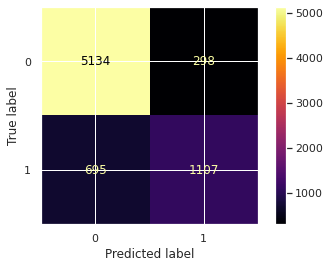

In [20]:
ConfusionMatrixDisplay.from_predictions(y_test, rf.predict(X_test), cmap='inferno')

# trying feature selection on Adult

In [21]:
from featurewiz import featurewiz

Imported version = 0.1.60.
from featurewiz import FeatureWiz
wiz = FeatureWiz(verbose=1)
X_train_selected = wiz.fit_transform(X_train, y_train)
X_test_selected = wiz.transform(X_test)
wiz.features  ### provides a list of selected features ###
                                


############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
**INFO: featurewiz can now read feather formatted files. Loading train data...
    Shape of your Data Set loaded: (30139, 15)
    Loaded train data. Shape = (30139, 15)
    Some column names had special characters which were removed...
No test data filename given...
Classifying features using a random sample of 10000 rows from dataset...
#### Single_Label Binary_Classification problem ####
    loading a random sample of 10000 rows into pandas for EDA
#####################################

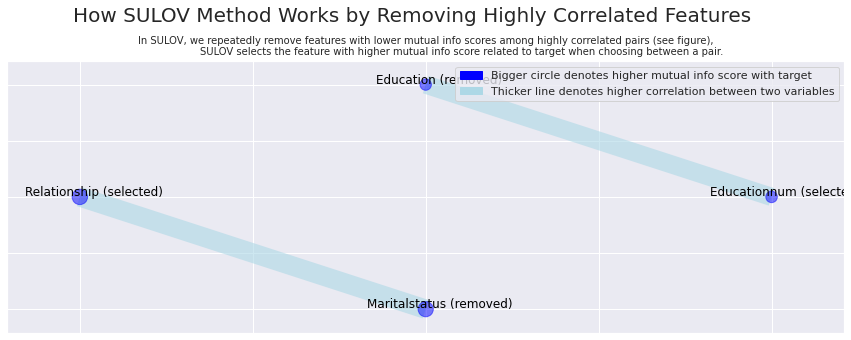

Time taken for SULOV method = 1 seconds
    Adding 0 categorical variables to reduced numeric variables  of 12
Final list of selected vars after SULOV = 12
Readying dataset for Recursive XGBoost by converting all features to numeric...
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
Train and Test loaded into Dask dataframes successfully after feature_engg completed
Current number of predictors = 12 
    XGBoost version: 1.6.1
Number of booster rounds = 100
        using 12 variables...
            Time taken for regular XGBoost feature selection = 2 seconds
        using 10 variables...
            Time taken for regular XGBoost feature selection = 2 seconds
        using 8 variables...
            Time taken for regular XGBoost feature selection 

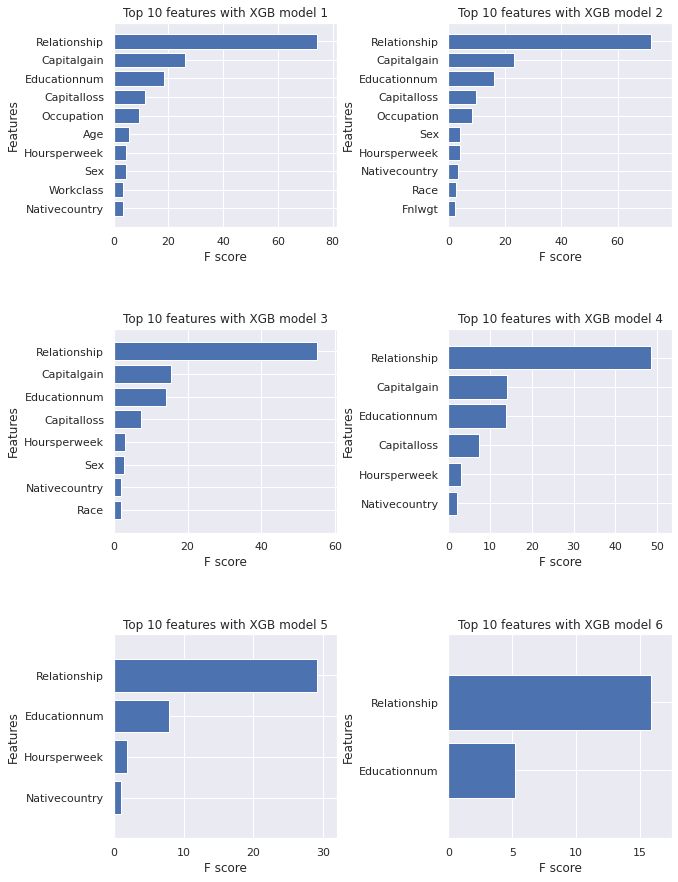

            Total time taken for XGBoost feature selection = 4 seconds
#######################################################################################
#####          F E A T U R E   S E L E C T I O N   C O M P L E T E D            #######
#######################################################################################
Selected 12 important features:
['Relationship', 'Capitalgain', 'Educationnum', 'Capitalloss', 'Occupation', 'Age', 'Hoursperweek', 'Sex', 'Workclass', 'Nativecountry', 'Race', 'Fnlwgt']

    Time taken for feature selection = 4 seconds
Returning 2 dataframes: dataname and test_data with 12 important features.


In [22]:
features, train = featurewiz(df, target='Target', corr_limit=0.7, verbose=2, header=0,test_data="", feature_engg="", category_encoders="")

In [23]:
features

['Relationship',
 'Capital-gain',
 'Education-num',
 'Capital-loss',
 'Occupation',
 'Age',
 'Hours-per-week',
 'Sex',
 'Workclass',
 'Native-country',
 'Race',
 'Fnlwgt']

In [26]:
set(df.columns.to_list()) - set(features)

{'Education', 'Marital-status', 'Target'}

In [28]:
df_featsel = df.drop(labels=['Education', 'Marital-status'], axis=1)

In [33]:
X_train_fs = train[features].to_numpy()
X_test_fs = test[features].to_numpy()

In [36]:
X_train.shape

(16877, 14)

In [37]:
X_train_fs.shape

(30139, 12)

,Relationship,Capital-gain,Education-num,Capital-loss,Occupation,Age,Hours-per-week,Sex,Workclass,Native-country,Race,Fnlwgt,Target
0,0.106689,2174,13,0,0.133907,39,40,0.313955,0.268960,0.254411,0.263855,77516,0
1,0.455728,0,13,0,0.485342,50,13,0.313955,0.285829,0.254411,0.263855,83311,0
2,0.106689,0,9,0,0.061527,38,40,0.313955,0.218918,0.254411,0.263855,215646,0
3,0.455728,0,7,0,0.061527,53,40,0.313955,0.218918,0.254411,0.129972,234721,0
4,0.493599,0,13,0,0.448686,28,40,0.113783,0.218918,0.271739,0.129972,338409,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,0.493599,0,12,0,0.305159,27,38,0.113783,0.218918,0.254411,0.263855,257302,0
32557,0.455728,0,9,0,0.124236,40,40,0.313955,0.218918,0.254411,0.263855,154374,1
32558,0.066334,0,9,0,0.133907,58,40,0.113783,0.218918,0.254411,0.263855,151910,0
32559,0.014343,0,9,0,0.133907,22,20,0.313955,0.218918,0.254411,0.263855,201490,0


In [34]:
rf2 = create_random_forest(X_train_fs, y_train)

ValueError: Found input variables with inconsistent numbers of samples: [30139, 16877]